
## Project : Brain Tumor Detector
In this project we used a convolutional neural network of Google (MobileNetV2) with more than 2.5 million of parameters. This CNN was conected with a output neural network which will predict the probabilities of a given image have a tumor or not. This tecnique is known as transfer learning, by analogy we can think of it in the same way that the human brain can learn a new task by using different areas of the brain.

## Data Base and Image Processing
The was taken from the [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) dataset which was used 155 tumographys without tumors on it and 98 with tumors. To increase the dataset it was used data agumentation


![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs40998-021-00426-9/MediaObjects/40998_2021_426_Fig10_HTML.png)

## Results
The precision reached was approximately **94%** which realtivaly right given the small trainig set. To increase the precision and make the model more robust it would be need more images and preferable new images from different sources.


### Importing some important libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras import regularizers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 30
EPOCHS = 50
CHANNEL = 3

### Converting dataset into batches

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-dataset/brain_tumor_dataset_',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 253 files belonging to 2 classes.


2023-01-01 17:15:06.597556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 17:15:06.598501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 17:15:06.739496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 17:15:06.740409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 17:15:06.741213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [4]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [5]:
len(dataset)

9

2023-01-01 17:15:10.417995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


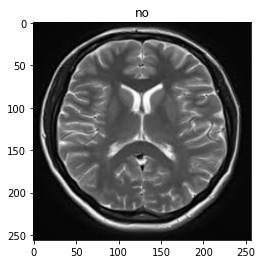

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


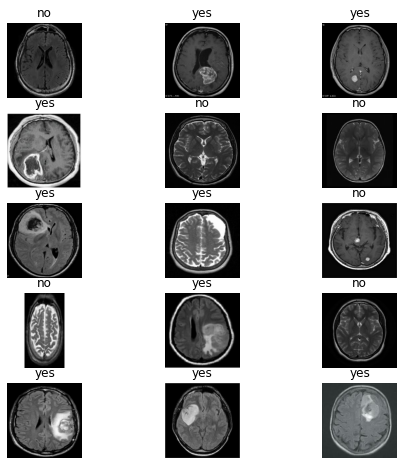

In [7]:
plt.figure(figsize = (8,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(5,3,i+1)
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Creating a function for spliting datset into train, test and validation

In [8]:
def dataset_partitions(ds, train_split = 0.6, test_split=0.2, val_split=0.2, shuffle = True, shuffle_size = 5):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)               # it takes 80% data from dataset 'ds'
    val_ds = ds.skip(train_size).take(val_size)  # it takes 10% data from remaining 20% data of dataset
    test_ds = ds.skip(train_size).skip(val_size) # it takes remaining 10% data from dataset
    
    return train_ds, val_ds, test_ds

In [9]:
len(dataset)

9

In [10]:
train_ds, val_ds, test_ds = dataset_partitions(dataset)

In [11]:
len(train_ds)

5

In [12]:
len(val_ds)

1

In [13]:
len(test_ds)

3

### for increasing the training performance fast we perform some operations

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Preprocessing

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### for making model more robust we use data augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)  
])

### Building Model with transfer learning

In [17]:
rede_google = MobileNetV2(include_top=False,weights="imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
rede_google.trainable = False

In [19]:
media_global = tf.keras.layers.GlobalAveragePooling2D() 

In [20]:
n_classes = 3

models = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    rede_google,
    media_global,
   
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),        
])

In [21]:
models.build(input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNEL))

### Summary of model

In [22]:
models.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (30, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (30, 256, 256, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (30, 1280)                0         
_________________________________________________________________
dense (Dense)                (30, 64)                  81984     
_________________________________________________________________
dense_1 (Dense)              (30, 3)                   195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_______________________________________

### Compilation of model

In [23]:
models.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Model fitting

In [24]:
history = models.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-01-01 17:15:21.755353: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.3684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


5/5 [==============================] - 14s 472ms/step - loss: 1.0813 - accuracy: 0.3684 - val_loss: 0.4897 - val_accuracy: 0.7333
Epoch 2/50
5/5 [==============================] - 0s 62ms/step - loss: 0.5949 - accuracy: 0.7068 - val_loss: 0.5288 - val_accuracy: 0.7000
Epoch 3/50
5/5 [==============================] - 0s 61ms/step - loss: 0.4880 - accuracy: 0.7895 - val_loss: 0.3178 - val_accuracy: 0.9000
Epoch 4/50
5/5 [==============================] - 0s 62ms/step - loss: 0.3999 - accuracy: 0.8421 - val_loss: 0.2785 - val_accuracy: 0.9333
Epoch 5/50
5/5 [==============================] - 0s 69ms/step - loss: 0.3255 - accuracy: 0.8571 - val_loss: 0.2306 - val_accuracy: 0.9333
Epoch 6/50
5/5 [==============================] - 0s 62ms/step - loss: 0.3267 - accuracy: 0.8872 - val_loss: 0.1743 - val_accuracy: 0.9667
Epoch 7/50
5/5 [==============================] - 0s 63ms/step - loss: 0.2875 - accuracy: 0.8947 - val_loss: 0.1735 - val_accuracy: 0.9333
Epoch 8/50
5/5 [====================

### Checking Scores of model

In [25]:
scores = models.evaluate(test_ds)
loss, accuracy = scores

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


3/3 [==============================] - 1s 40ms/step - loss: 0.1477 - accuracy: 0.9315


In [26]:
print("Accuracy of model is : ",accuracy*100)
print("Loss of model is : ",loss*100)

Accuracy of model is :  93.1506872177124
Loss of model is :  14.765927195549011


### Plotting graph for better understanding between validation and training

In [27]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & Validation Accuracy')

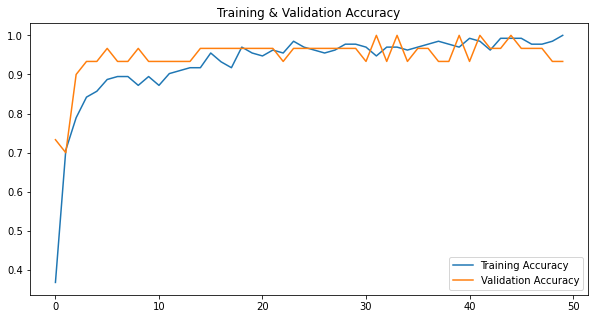

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),accu,label="Training Accuracy")
plt.plot(range(EPOCHS),val_accu,label="Validation Accuracy")

plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

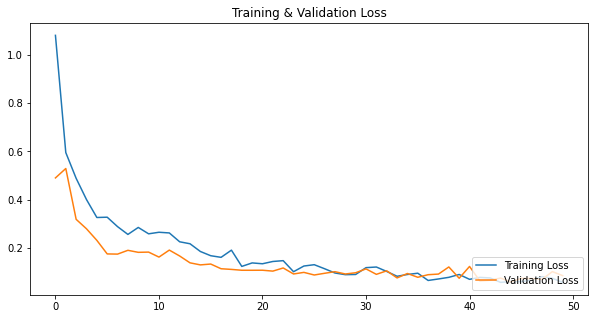

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)

plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")

plt.legend(loc='lower right')
plt.title('Training & Validation Loss')

first image to predict
actual:  no
predicted :  no


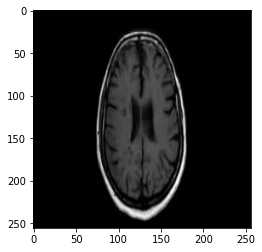

In [30]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual: ',class_names[first_label])
    
    batch_prediction = models.predict(images_batch)
    print('predicted : ',class_names[np.argmax(batch_prediction[0])])

### Creating a function for making prediction with confidence score

In [31]:
def predict(models,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creating a batch
    
    predictions = models.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round((np.max(predictions[0])*100),2)
    return predicted_class, confidence

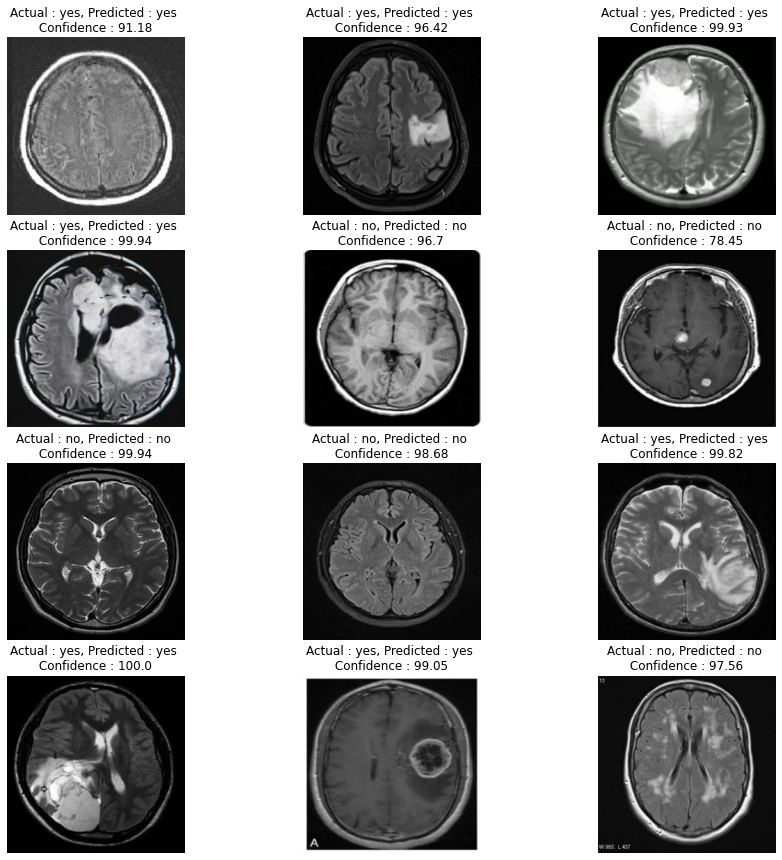

In [32]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(models, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual : {actual_class}, Predicted : {predicted_class} \n Confidence : {confidence} ',)
        plt.axis('off')